<a href="https://colab.research.google.com/github/ghanbarifereshteh/singlecolorprj/blob/main/RNN2Forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
#import all libraries
#11/26/2023
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import TimeDistributed
from tensorflow.keras import datasets, layers, models
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,RNN
from keras.layers import Dropout,Attention
import IPython
import IPython.display
from math import floor

In [77]:
import yfinance as yf
df_stock = yf.download('EURUSD=X','2003-12-01','2023-11-01')

[*********************100%%**********************]  1 of 1 completed


In [78]:
#set hyper parameters.there is a sequence. the network sees the input days and predicts the other days. seq_len is the sum of inputs and offsets.
n_steps = 2
n_neurons = 800
n_layers = 3
learning_rate = 0.000097
batch_size = 64
dropout_rate = 0.2
num_features = 1

For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

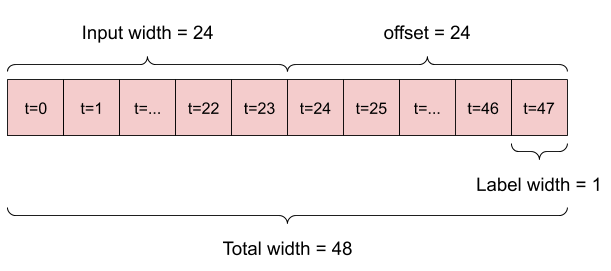

In [79]:
#the data must be normalized so it becomes understandable for machine.
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range = (0,1))
    #df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    #df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    #df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df,min_max_scaler

In [80]:
#spilite data and and make three datasets for training and validation and test.
def spilitData(df_stock_norm):
  n = len(df_stock_norm)
  train_df = df_stock_norm[0:int(n*0.8)]
  val_df = df_stock_norm[int(n*0.8):int(n*0.9)]
  test_df = df_stock_norm[int(n*0.9):]

  #num_features = df_stock_norm.shape[1]
  return train_df,val_df,test_df

In [81]:
#because of normalization(between 0 and 1) some values become zero. in calculating the amount of profit, we may encounter divide by zero error. so zero values are deleted with this function.
def drop_zeros(df_stock):
  mask = (df_stock.drop(columns=['Volume']) == 0).any(axis=1)
  removed_rows = df_stock[mask]
  df_stock = df_stock[~mask]

  # Display the removed rows
  print("Removed Rows:")
  print(removed_rows)
  return df_stock

In [82]:
class WindowGenerator():

  def __init__(self,df,input_width, label_width, shift,label_columns=None):
    # Work out the label column indices.
    self.column_indices ={name: i for i, name in enumerate(df.columns)}
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [83]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  return inputs, labels

WindowGenerator.split_window = split_window

In [84]:
#this function makes datasets like timeseries so they becomes suitable for a RNN network.
def make_dataset(self, data):

  data = np.array(data, dtype=np.float32)

  ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size= batch_size)

  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [85]:
# the model consists of many RNN layers. each layer has many neurons. we increased the number of neurons and saw the accuracy improved.
# after RNN layers, there is a Dense layer that outputs six features.
# to avoid overfitting and also enhancing the model, we added a dropout.
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    layers = [tf.keras.layers.GRUCell(units=n_neurons, activation='tanh')
         for layer in range(n_layers)]

  # Create a multi-layer RNN cell
    self.lstm_cell = tf.keras.layers.StackedRNNCells(layers)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dense = tf.keras.layers.Dense(num_features,activation = 'relu')

In [86]:
feedback_model = FeedBack(units=n_neurons, out_steps = n_steps)

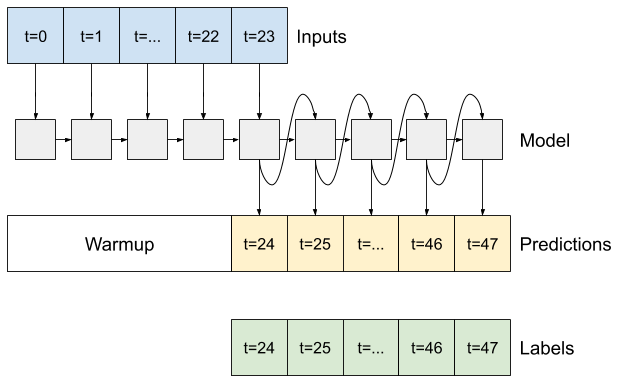

In [87]:
#give the model time to warm up its internal state before making a single prediction
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)
  # predictions.shape => (batch, features)
  prediction = self.dense(x)

  return prediction, state

FeedBack.warmup = warmup

In [88]:
# this call function as you see in the image above, gets the predictions and gives them as input to the model again..
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                          training=training)
    if training:
      x = self.dropout(x)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [89]:
def stacked_RNN():
  layers = [tf.keras.layers.GRUCell(units=n_neurons, activation='elu')
         for layer in range(n_layers)]

  # Create a multi-layer RNN cell
  multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)

  # Define the RNN layer using the Sequential API
  model = tf.keras.Sequential([
      tf.keras.layers.RNN(multi_layer_cell, return_sequences=True),
      tf.keras.layers.Reshape(target_shape=(-1, n_neurons)),
      tf.keras.layers.Dense(num_features)
  ])
  return model

In [90]:
def simple_RNN():

  # Define the RNN layer using the Sequential API
  model = tf.keras.Sequential()
  model.add(SimpleRNN(units=50, activation='tanh',return_sequences=True,input_shape=(n_steps,1))),
  model.add(layers.Dropout(0.2)),
  model.add(SimpleRNN(units=50, activation='tanh',return_sequences=True)),
  model.add(Dropout(0.2)),
  model.add(SimpleRNN(units=50, activation='tanh',return_sequences=True)),
  model.add(Dropout(0.2)),
  model.add(SimpleRNN(units=50, activation='tanh')),
  model.add(Dropout(0.2)),
  model.add(Dense(units=1))

  return model

In [91]:
#MAX_EPOCHS = 150

def compile_and_fit(model, window,epoch, patience=10):
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
   #                                                 patience=patience,
    #                                                mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                metrics=[tf.keras.losses.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=epoch,
                      validation_data=window.val)
                     # callbacks=[early_stopping])
  return history

In [92]:
 #for ploting and comparing target values and predictions, we need labels..
 #this function seperate inputs and labels from dataset.
 def get_input_Labels(ds):
  ds_inputs = []
  ds_labels = []
  for inputs, labels in ds:
      ds_inputs.append(inputs.numpy())
      ds_labels.append(labels.numpy())
  batch_input = []
  batch_labels = []
  for i in range(len(ds_labels)):
    for j in range(len(ds_labels[i])):
      batch_labels.append(ds_labels[i][j])
      batch_input.append(ds_inputs[i][j])
  return np.array(batch_input),np.array(batch_labels)

In [93]:
def plot_target_predict(test_labels,predictions):
  # ploting the graph
  #comp = pd.DataFrame({'Column1':test_labels[:,-1,:][:,3],'Column2':predictions[:,-1,:][:,3]})
  #plt.figure(figsize=(20,5))
  #plt.plot(comp['Column1'], color='orange', label='Target')
  #plt.plot(comp['Column2'], color='red', label='Prediction')
  #plt.legend()
  #plt.show()
  plt.figure(figsize=(10,3))
  plt.plot(predictions[:,-1,:],color='orange', label='Target')
  plt.plot(test_labels[:,-1,:], color='red', label='Prediction')
  plt.legend()
  plt.show()

In [94]:
def plot(history):
  acc = history.history['mean_absolute_error']
  val_acc = history.history['val_mean_absolute_error']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [95]:
#it seems ploting is not enough for evaluating model. with this function the amount of profit will be obtained based on predictions.
def calculate_profit(predictions,test_inputs):
  capital = 0
  yesterday_capital = 100
  amount_of_profit = 0
  amount_of_daily_profit = []
  capital_array = []
  direction = []
  print("i"+str(len(predictions)))
  for i in range(1,len(predictions)):
    if(test_inputs[i-1,0]==0 or test_inputs[i,0]==0):
            print("i zero...else..."+str(i))
    else:
      if (test_inputs[i,0] > test_inputs[i-1,0]):
        if(predictions[i,0] > test_inputs[i-1,0]):
          today_profit = ((min(predictions[i,0],test_inputs[i,0])-test_inputs[i-1,0])/test_inputs[i-1,0]) *10000
          direction.append(1)
        else:
          today_profit = -((test_inputs[i,0] - test_inputs[i-1,0])/test_inputs[i-1,0])*10000
          direction.append(0)
      else:
        if (predictions[i,0] <test_inputs[i-1,0] ):
          today_profit = ((test_inputs[i-1,0] - max(predictions[i,0],test_inputs[i,0]))/test_inputs[i-1,0]) * 10000
          direction.append(1)
        else:
          today_profit = ((test_inputs[i,0]-test_inputs[i-1,0])/test_inputs[i-1,0])*10000
          direction.append(0)
      today_capital = yesterday_capital * (1 + today_profit * 0.0001)
      print("today capital..."+str(today_capital))
      print("today profit..."+str(today_profit))
      capital_array.append(today_capital)
      yesterday_capital = today_capital
      amount_of_profit += today_profit
      amount_of_daily_profit.append(today_profit)
  return amount_of_profit,amount_of_daily_profit,yesterday_capital,capital_array,direction

In [96]:
#in dynamic LSTM method, the actual value of the recently predicted
#date is added to the training dataset to rebuild the model to make predictions for data in
#the testing set
def dynamicLSTM(window,test_inputs,test_labels):
  val_inputs,val_labels = get_input_Labels(window.val)
  len_recent_data = 10
  i = 0
  new_predictions = np.empty(shape = (0,n_steps,num_features))
  print("len new pre..."+str(len(new_predictions)))
  iteration = floor(len(test_inputs)/len_recent_data)
  while i < iteration*len_recent_data :
      npredictions = feedback_model.predict(test_inputs[i:i+len_recent_data])
      new_predictions = np.concatenate((new_predictions, npredictions), axis=0)
      combined_data = np.concatenate((val_inputs, test_inputs[i:i+len_recent_data]), axis=0)
      combined_data_labels = np.concatenate((val_labels, test_labels[i:i+len_recent_data]), axis=0)
      window.val = window.make_dataset(combined_data[:,-1,:],64)
      feedback_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

      history = feedback_model.fit(combined_data,combined_data_labels, epochs=7,
                        validation_data=window.val)
      i += len_recent_data
      print("itrration....."+str(i))
  print("last i...."+str(i))
  npredictions = feedback_model.predict(test_inputs[i:])
  mse,mae = feedback_model.evaluate(test_inputs)
  new_predictions = np.concatenate((new_predictions, npredictions), axis=0)
  plot_target_predict(test_labels,new_predictions)
  amount_of_profit = calculate_profit(new_predictions ,test_inputs)
  print("amount of profit....dynamic LSTM..."+str(amount_of_profit))

In [97]:
def compile_model(model,multi_window,epoch):
  history = compile_and_fit(model, multi_window,epoch)
  predictions = model.predict(multi_window.test)
  #mse,mae = model.evaluate(multi_window.test)
  test_inputs,test_labels = get_input_Labels(multi_window.test)
  plot_target_predict(test_labels,predictions)
  #profit,list_profit = calculate_profit(predictions,test_inputs)
  #print("profit...."+str(profit))
  #print("mse,mae...."+str(mse)+", "+str(mae))
  return history,predictions

In [98]:
  def run_stacked_RNN():
    model = stacked_RNN()
    return model

In [99]:
def run_simple_RNN():
  model = simple_RNN()
  return model

In [100]:
def get_input_CNN(df_stock):
  df_stock,scaler = normalize_data(df_stock)
  df_stock = drop_zeros(df_stock)
  train_df,val_df,test_df = spilitData(df_stock)

  multi_window = WindowGenerator(train_df,input_width=n_steps,
                                label_width=n_steps,
                                shift=1)
  multi_window.train = multi_window.make_dataset(train_df)
  multi_window.val = multi_window.make_dataset(val_df)
  multi_window.test = multi_window.make_dataset(test_df)
  train_inputs,train_labels = get_input_Labels(multi_window.train)
  val_inputs,val_labels = get_input_Labels(multi_window.val)
  test_inputs,test_labels = get_input_Labels(multi_window.test)
  subsequences = 4
  timesteps = train_inputs.shape[1]//subsequences

  X_train_series_sub = train_inputs.reshape((train_inputs.shape[0], subsequences, timesteps, num_features))
  X_valid_series_sub = val_inputs.reshape((val_inputs.shape[0], subsequences, timesteps, num_features))
  y_train_series_sub = train_inputs.reshape((train_labels.shape[0], subsequences, timesteps, num_features))
  y_valid_series_sub = val_inputs.reshape((val_labels.shape[0], subsequences, timesteps, num_features))
  X_test_series_sub = test_inputs.reshape((test_inputs.shape[0], subsequences, timesteps, num_features))
  return X_train_series_sub,train_inputs,train_labels,X_valid_series_sub,val_inputs,val_labels,X_test_series_sub,test_inputs,test_labels,scaler


In [101]:
def time_distributed_CNN_RNN(df_stock,epochs):
  X_train_series_sub,train_inputs,train_labels,X_valid_series_sub,val_inputs,val_labels,X_test_series_sub,test_inputs,test_labels,scaler = get_input_CNN(df_stock)
  layers = [tf.keras.layers.LSTMCell(units=n_neurons, activation='elu')
          for layer in range(n_layers)]

  # Create a multi-layer RNN cell
  multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)

  input_layer = tf.keras.layers.Input(shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3]))
  conv1d_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu'))(input_layer)
  maxpooling_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2))(conv1d_layer)
  flatten_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(maxpooling_layer)
  lstm_layer = tf.keras.layers.LSTM(800,activation='relu')(flatten_layer)
  output_layer = tf.keras.layers.Dense(n_steps*num_features)(lstm_layer)
  final_layer = tf.keras.layers.Reshape([n_steps, num_features])(output_layer)
  #print("dense shape..."+str(final_layer .shape))

  model_cnn_lstm = tf.keras.Model(inputs=input_layer, outputs=final_layer)
  model_cnn_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate= 0.00006),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
  cnn_history = model_cnn_lstm.fit(X_train_series_sub, train_labels, validation_data=(X_valid_series_sub, val_labels), epochs=epochs, verbose=2)
  pred = model_cnn_lstm.predict(X_test_series_sub)

  return model_cnn_lstm,cnn_history,scaler

In [102]:
def cocatenated_CNN_RNN(df_stock,epochs):
  X_train_series_sub,train_inputs,train_labels,X_valid_series_sub,val_inputs,val_labels,X_test_series_sub,test_inputs,test_labels,scaler = get_input_CNN(df_stock)
  layers = [tf.keras.layers.LSTMCell(units=n_neurons, activation='elu')
          for layer in range(n_layers)]

  # Create a multi-layer RNN cell
  multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)

  input_layer = tf.keras.layers.Input(shape=(train_inputs.shape[1], train_inputs.shape[2]))
  print("input layer..."+str(input_layer.shape))
  conv1d_layer = tf.keras.layers.Conv1D(128,4,strides=1, padding='same',activation='relu')(input_layer)
  print("conv1d_layer..."+str(conv1d_layer.shape))
  lstm_layer = tf.keras.layers.LSTM(128,activation='relu',return_sequences=True,dtype=tf.float32)(input_layer)
  print("lstm_layer..."+str(lstm_layer.shape))
  concat = tf.keras.layers.Concatenate(axis=-1)([conv1d_layer, lstm_layer])
  flatten_concat = tf.keras.layers.Flatten()(concat)
  output_layer = tf.keras.layers.Dense(n_steps*num_features)(flatten_concat)
  final_layer = tf.keras.layers.Reshape([n_steps, num_features])(output_layer)
  print("dense shape..."+str(final_layer .shape))

  model_cnn_lstm = tf.keras.Model(inputs=input_layer, outputs=final_layer)
  model_cnn_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
  cnn_history = model_cnn_lstm.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=epochs, verbose=2)
  pred = model_cnn_lstm.predict(test_inputs)
  mse,mae = model_cnn_lstm.evaluate(test_inputs,test_labels)
  pred = scaler.inverse_transform(pred[:,-1,:])
  test_labels = scaler.inverse_transform(test_labels[:,-1,:])
  test_inputs = scaler.inverse_transform(test_inputs[:,-1,:])
  plt.figure(figsize=(10,3))
  plt.plot(pred[:,3],color='orange', label='Target')
  plt.plot(test_labels[:,3], color='red', label='Prediction')
  plt.legend()
  plt.show()
  return model_cnn_lstm,cnn_history,scaler,test_inputs,test_labels,pred

In [103]:
def LSTM_Conv3d(df_stock,epochs):
  X_train_series_sub,train_inputs,train_labels,X_valid_series_sub,val_inputs,val_labels,X_test_series_sub,test_inputs,test_labels = get_input_CNN(df_stock)
  layers = [tf.keras.layers.LSTMCell(units=n_neurons, activation='elu')
          for layer in range(n_layers)]

  # Create a multi-layer RNN cell
  multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)

  input_layer = tf.keras.layers.Input(shape=(train_inputs.shape[1], train_inputs.shape[2]))
  lstm_layer = tf.keras.layers.LSTM(800,return_sequences=True,activation='relu')(input_layer)
  print("input layer..."+str(input_layer.shape))
  conv1d_layer = tf.keras.layers.Conv1D(128,4,strides=1, padding='same',activation='relu')(lstm_layer)
  conv1d_layer = tf.keras.layers.Flatten()(conv1d_layer)
  conv1d_layer = tf.keras.layers.Reshape([32,10,8])(conv1d_layer)
  conv2d_layer = tf.keras.layers.Conv2D(128,4,strides=1, padding='same',activation='relu')(conv1d_layer)
  conv2d_layer = tf.keras.layers.Flatten()(conv2d_layer)
  conv2d_layer = tf.keras.layers.Reshape([32,16,10,8])(conv2d_layer)
  conv3d_layer = tf.keras.layers.Conv3D(128,4,strides=1, padding='same',activation='relu')(conv2d_layer)

  flatten_concat = tf.keras.layers.Flatten()(conv3d_layer)
  output_layer = tf.keras.layers.Dense(n_steps*num_features)(flatten_concat)
  final_layer = tf.keras.layers.Reshape([n_steps, num_features])(output_layer)
  print("dense shape..."+str(final_layer .shape))

  model_cnn_lstm = tf.keras.Model(inputs=input_layer, outputs=final_layer)
  model_cnn_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate ),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
  cnn_history = model_cnn_lstm.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=epochs, verbose=2)
  pred = model_cnn_lstm.predict(test_inputs)
  mse, mae = model_cnn_lstm.evaluate(test_inputs)
  plot_target_predict(test_labels,pred)
  profit = calculate_profit(pred,test_inputs)
  print("profit...."+str(profit))
  print("mse, mae...."+str(mse)+", "+str(mae))
  return cnn_history,pred


In [104]:
def time_distributed_Concatenated(df_stock,epochs):
  X_train_series_sub,train_inputs,train_labels,X_valid_series_sub,val_inputs,val_labels,X_test_series_sub,test_inputs,test_labels = get_input_CNN(df_stock)
  layers = [tf.keras.layers.LSTMCell(units=n_neurons, activation='elu')
          for layer in range(n_layers)]

  # Create a multi-layer RNN cell
  multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)

  input_layer = tf.keras.layers.Input(shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3]))
  conv1d_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))(input_layer)
  maxpooling_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2))(conv1d_layer)
  flatten_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(maxpooling_layer)
  lstm_layer = tf.keras.layers.LSTM(800,activation='relu')(flatten_layer)
  final_layer1 = tf.keras.layers.Flatten()(lstm_layer)

  input_layer2 = tf.keras.layers.Reshape([n_steps, num_features])(input_layer)
  conv1d_layer = tf.keras.layers.Conv1D(128,4,strides=1, padding='same',activation='relu')(input_layer2)
  print("conv1d_layer..."+str(conv1d_layer.shape))

  lstm_layer = tf.keras.layers.LSTM(128,return_sequences=True,activation='relu')(input_layer2)
  attention = Attention()([lstm_layer, conv1d_layer])
  concat = tf.keras.layers.Concatenate(axis=-1)([attention, lstm_layer])
  flatten_concat = tf.keras.layers.Flatten()(concat)

  concat = tf.keras.layers.Concatenate(axis=-1)([flatten_concat, final_layer1])
  flatten_concat = tf.keras.layers.Flatten()(concat)
  output_layer = tf.keras.layers.Dense(n_steps*num_features)(flatten_concat)
  final_layer2 = tf.keras.layers.Reshape([n_steps, num_features])(output_layer)
  print("dense shape..."+str(final_layer2 .shape))

  model_cnn_lstm = tf.keras.Model(inputs=input_layer, outputs=final_layer2)
  model_cnn_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
  cnn_history = model_cnn_lstm.fit(X_train_series_sub, train_labels, validation_data=(X_valid_series_sub, val_labels), epochs=epochs, verbose=2)
  pred = model_cnn_lstm.predict(X_test_series_sub)
  mse, mae = model_cnn_lstm.evaluate(X_test_series_sub)
  plot_target_predict(test_labels,pred)
  profit = calculate_profit(pred,test_inputs)
  print("profit...."+str(profit))
  print("mse, mae...."+str(mse)+", "+str(mae))
  return  model_cnn_lstm,cnn_history,pred

**Results of Stacked RNN in different currency pairs:**

In [105]:
df_stock = yf.download('EURUSD=X','2000-01-01','2023-11-11')
df_stock = df_stock.drop(columns=['Volume','Open','High','Low','Adj Close'])

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df_stock = drop_zeros(df_stock)

In [ ]:
df_stock

,Close
Date,
2003-12-01,1.196501
2003-12-02,1.208897
2003-12-03,1.212298
2003-12-04,1.208094
2003-12-05,1.218695
...,...
2023-11-06,1.073215
2023-11-07,1.072156
2023-11-08,1.069610


In [ ]:
len(df_stock)

5176

In [ ]:
df_stock

,Close
Date,
2003-12-01,1.196501
2003-12-02,1.208897
2003-12-03,1.212298
2003-12-04,1.208094
2003-12-05,1.218695
...,...
2023-11-06,1.073215
2023-11-07,1.072156
2023-11-08,1.069610


In [ ]:
scaler , df_stock = normalize_data(df_stock)
train_df,val_df,test_df = spilitData(df_stock)
train_df = train_df.Close.values
val_df = val_df.Close.values
test_df = test_df.Close.values
train_df = np.reshape(train_df,(-1,1))
val_df = np.reshape(val_df,(-1,1))
test_df = np.reshape(test_df,(-1,1))
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []
for i in range(n_steps,len(train_df)):
  x_train.append(train_df[i-n_steps:i,0])
  y_train.append(train_df[i,0])
x_train = np.array(x_train)
y_train = np.array(y_train)
for i in range(n_steps,len(val_df)):
  x_val.append(val_df[i-n_steps:i,0])
  y_val.append(val_df[i,0])
x_val = np.array(x_val)
y_val = np.array(y_val)
for i in range(n_steps,len(test_df)):
  x_test.append(test_df[i-n_steps:i,0])
  y_test.append(test_df[i,0])
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1],1))
y_val = np.reshape(y_val, (y_val.shape[0],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("Shape of X_train after reshape :",x_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (4122, 20, 1)
Shape of y_train after reshape : (4122, 1)


In [ ]:
model = run_simple_RNN()
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0009),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=50,batch_size=64, verbose=2)

Epoch 1/50
65/65 - 10s - loss: 0.3086 - mean_absolute_error: 0.4353 - val_loss: 6.4620e-04 - val_mean_absolute_error: 0.0196 - 10s/epoch - 156ms/step
Epoch 2/50
65/65 - 4s - loss: 0.1452 - mean_absolute_error: 0.3026 - val_loss: 0.0010 - val_mean_absolute_error: 0.0255 - 4s/epoch - 66ms/step
Epoch 3/50
65/65 - 6s - loss: 0.0906 - mean_absolute_error: 0.2406 - val_loss: 8.8628e-04 - val_mean_absolute_error: 0.0213 - 6s/epoch - 99ms/step
Epoch 4/50
65/65 - 4s - loss: 0.0599 - mean_absolute_error: 0.1950 - val_loss: 0.0012 - val_mean_absolute_error: 0.0258 - 4s/epoch - 63ms/step
Epoch 5/50
65/65 - 5s - loss: 0.0450 - mean_absolute_error: 0.1675 - val_loss: 9.7197e-04 - val_mean_absolute_error: 0.0217 - 5s/epoch - 76ms/step
Epoch 6/50
65/65 - 6s - loss: 0.0349 - mean_absolute_error: 0.1469 - val_loss: 0.0022 - val_mean_absolute_error: 0.0442 - 6s/epoch - 92ms/step
Epoch 7/50
65/65 - 4s - loss: 0.0266 - mean_absolute_error: 0.1288 - val_loss: 0.0078 - val_mean_absolute_error: 0.0859 - 4s/ep

In [ ]:
model.summary()

In [ ]:

  pred = model.predict(x_test)
  plt.figure(figsize=(10,3))
  plt.plot(pred,color='orange', label='Target')
  plt.plot(y_test, color='red', label='Prediction')
  plt.legend()
  plt.show()

In [ ]:
mse , mae = model.evaluate(x_test,y_test)

16/16 [==============================] - 1s 9ms/step - loss: 1.0341e-04 - mean_absolute_error: 0.0071


In [106]:
 df_stock,scaler = normalize_data(df_stock)
#df_stock = drop_zeros(df_stock)
train_df,val_df,test_df = spilitData(df_stock)

multi_window = WindowGenerator(train_df,input_width=n_steps,
                              label_width=n_steps,
                              shift=1)
multi_window.train = multi_window.make_dataset(train_df)
multi_window.val = multi_window.make_dataset(val_df)
multi_window.test = multi_window.make_dataset(test_df)

In [ ]:
model = run_stacked_RNN()
history,predictions = compile_model(model,multi_window,100)

Epoch 1/100
65/65 [==============================] - 8s 49ms/step - loss: 2.2278e-04 - mean_absolute_error: 0.0093 - val_loss: 5.0164e-05 - val_mean_absolute_error: 0.0051
Epoch 2/100
65/65 [==============================] - 2s 29ms/step - loss: 5.9632e-04 - mean_absolute_error: 0.0177 - val_loss: 2.5836e-04 - val_mean_absolute_error: 0.0127
Epoch 3/100
65/65 [==============================] - 2s 27ms/step - loss: 5.9713e-04 - mean_absolute_error: 0.0174 - val_loss: 5.3996e-05 - val_mean_absolute_error: 0.0057
Epoch 4/100
65/65 [==============================] - 2s 29ms/step - loss: 2.5721e-04 - mean_absolute_error: 0.0102 - val_loss: 7.4527e-05 - val_mean_absolute_error: 0.0062
Epoch 5/100
65/65 [==============================] - 2s 31ms/step - loss: 2.7834e-04 - mean_absolute_error: 0.0108 - val_loss: 6.4223e-05 - val_mean_absolute_error: 0.0058
Epoch 6/100
65/65 [==============================] - 3s 47ms/step - loss: 2.6579e-04 - mean_absolute_error: 0.0105 - val_loss: 7.5614e-05 - 

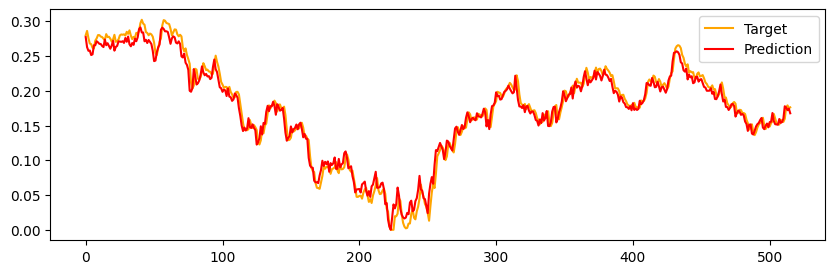

In [115]:
history,predictions = compile_model(feedback_model,multi_window,100)
test_inputs,test_labels = get_input_Labels(multi_window.test)


In [33]:
test_inputs.shape

(516, 2, 1)

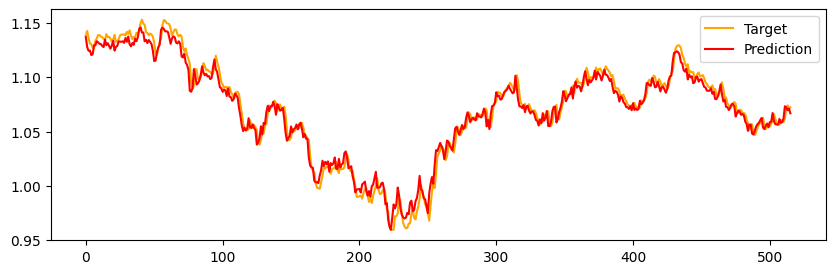

In [116]:
predictions = scaler.inverse_transform(predictions[:,-1,:])
test_inputs = scaler.inverse_transform(test_inputs[:,-1,:])
test_labels = scaler.inverse_transform(test_labels[:,-1,:])
plt.figure(figsize=(10,3))
plt.plot(predictions,color='orange', label='Target')
plt.plot(test_labels,color='red', label='Prediction')
plt.legend()
plt.show()

In [ ]:
profit1,list_profit1,capital1,capital_array1,direction1 = calculate_profit(predictions,test_inputs)

In [118]:
capital1

297.208306622517

In [137]:
direction1.count(0)

102

In [138]:
direction1.count(1)

413

In [139]:

variance = sum((x) ** 2 for x in list_profit1)


In [140]:
(variance** 0.5)/len(list_profit1)

1.8840056701174648

In [ ]:
model_cnn_lstm, history,scaler= time_distributed_CNN_RNN(df_stock,300)

Removed Rows:
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2008-03-17  0.963385  0.980316  0.000000  0.962460   1.574803       0
2022-09-27  0.004310  0.000000  0.585375  0.004306   0.962371       0
2022-09-28  0.000000  0.002549  0.581785  0.000000   0.959619       0


Epoch 1/300
129/129 - 14s - loss: 0.2514 - mean_absolute_error: 0.3506 - val_loss: 0.0116 - val_mean_absolute_error: 0.0868 - 14s/epoch - 107ms/step
Epoch 2/300
129/129 - 2s - loss: 0.0075 - mean_absolute_error: 0.0625 - val_loss: 0.0057 - val_mean_absolute_error: 0.0633 - 2s/epoch - 12ms/step
Epoch 3/300
129/129 - 2s - loss: 0.0021 - mean_absolute_error: 0.0297 - val_loss: 2.8642e-04 - val_mean_absolute_error: 0.0113 - 2s/epoch - 12ms/step
Epoch 4/300
129/129 - 3s - loss: 4.7714e-04 - mean_absolute_error: 0.0141 - val_loss: 1.7579e-04 - val_mean_absolute_error: 0.0090 - 3s/epoch - 22ms/step
Epoch 5/300
129/129 - 2s - loss: 4.1601e-04 - mean_absolute_error: 0.0130 - val_loss: 1.5070e-04 - val_mean_absolute_error: 0.0083 - 2s/epoch - 17ms/step
Epoch 6/300
129/129 - 2s - loss: 3.9041e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4255e-04 - val_mean_absolute_error: 0.0079 - 2s/epoch - 12ms/step
Epoch 7/300
129/129 - 2s - loss: 3.7718e-04 - mean_absolute_error: 0.0122 - val_loss: 1.3865e

Removed Rows:
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2008-03-17  0.963385  0.980316  0.000000  0.962460   1.574803       0
2022-09-27  0.004310  0.000000  0.585375  0.004306   0.962371       0
2022-09-28  0.000000  0.002549  0.581785  0.000000   0.959619       0
16/16 [==============================] - 0s 6ms/step - loss: 6.5519e-05 - mean_absolute_error: 0.0050


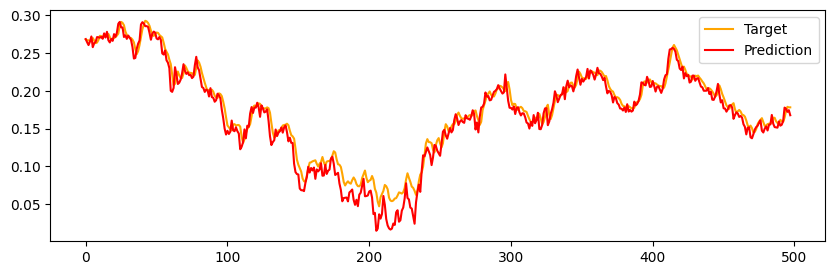

In [ ]:
  X_train_series_sub,train_inputs,train_labels,X_valid_series_sub,val_inputs,val_labels,X_test_series_sub,test_inputs,test_labels,scaler = get_input_CNN(df_stock)
  pred = model_cnn_lstm.predict(X_test_series_sub)
  mse,mae = model_cnn_lstm.evaluate(X_test_series_sub,test_labels)
  pred = scaler.inverse_transform(pred[:,-1,:])
  test_labels = scaler.inverse_transform(test_labels[:,-1,:])
  test_inputs = scaler.inverse_transform(test_inputs[:,-1,:])
  plt.figure(figsize=(10,3))
  plt.plot(pred[:,3],color='orange', label='Target')
  plt.plot(test_labels[:,3], color='red', label='Prediction')
  plt.legend()
  plt.show()

In [ ]:
profit,list_profit,capital,capital_array = calculate_profit(pred,test_inputs)
print("profit...."+str(profit))
print("mse, mae...."+str(mse)+", "+str(mae))

i498
today capital...100.41289874352515
today profit...0.004128987435251474
today capital...101.36664693560108
today profit...0.009498263709247112
today capital...99.88594040877226
today profit...-0.01460743322968483
today capital...101.63468858161737
today profit...0.01750745065510273
today capital...102.49525816795237
today profit...0.00846728216856718
today capital...105.03713663436424
today profit...0.02479996159672737
today capital...107.12884297612364
today profit...0.019913969561457634
today capital...107.39577997957085
today profit...0.002491737948730588
today capital...107.84327452192424
today profit...0.004166779574006796
today capital...107.500147226302
today profit...-0.003181721782311797
today capital...107.4522467044343
today profit...-0.0004455856396816671
today capital...107.08516324245467
today profit...-0.003416247433051467
today capital...107.40381855277646
today profit...0.0029757185839116573
today capital...109.0121171338552
today profit...0.014974314719438553
toda

In [ ]:
np.

In [ ]:
capital

16602.084108268846

In [ ]:
test_inputs[206]

array([0.], dtype=float32)

In [ ]:
test_inputs[205]

array([0.00430563], dtype=float32)

In [ ]:
list_profit[206]

10839.720964431763

In [ ]:
capital

26.5920109272445

In [ ]:
df_stock = yf.download('EURJPY=X','2000-01-01','2023-10-14')

In [ ]:
model = run_simple_RNN()
history,predictions = compile_model(model,100)

In [ ]:
model = run_stacked_RNN()
history,predictions = compile_model(model,100)

In [ ]:
history,predictions = compile_model(feedback_model,100)

In [ ]:
history,predictions = time_distributed_CNN_RNN(df_stock,300)

AttributeError: ignored

Removed Rows:
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2008-03-17  0.963385  0.980316  0.000000  0.962460   1.574803       0
2022-09-27  0.004310  0.000000  0.585375  0.004306   0.962371       0
2022-09-28  0.000000  0.002549  0.581785  0.000000   0.959619       0


input layer...(None, 20, 6)
conv1d_layer...(None, 20, 128)
lstm_layer...(None, 20, 128)
dense shape...(None, 20, 6)
Epoch 1/300
129/129 - 6s - loss: 0.0128 - mean_absolute_error: 0.0460 - val_loss: 1.2316e-04 - val_mean_absolute_error: 0.0075 - 6s/epoch - 49ms/step
Epoch 2/300
129/129 - 4s - loss: 2.9060e-04 - mean_absolute_error: 0.0107 - val_loss: 1.0579e-04 - val_mean_absolute_error: 0.0068 - 4s/epoch - 28ms/step
Epoch 3/300
129/129 - 7s - loss: 2.3257e-04 - mean_absolute_error: 0.0096 - val_loss: 8.5904e-05 - val_mean_absolute_error: 0.0062 - 7s/epoch - 55ms/step
Epoch 4/300
129/129 - 4s - loss: 1.5419e-04 - mean_absolute_error: 0.0077 - val_loss: 4.7777e-05 - val_mean_absolute_error: 0.0047 - 4s/epoch - 29ms/step
Epoch 5/300
129/129 - 4s - loss: 1.2701e-04 - mean_absolute_error: 0.0069 - val_loss: 4.3836e-05 - val_mean_absolute_error: 0.0046 - 4s/epoch - 32ms/step
Epoch 6/300
129/129 - 5s - loss: 1.1559e-04 - mean_absolute_error: 0.0065 - val_loss: 5.0463e-05 - val_mean_absolute_e

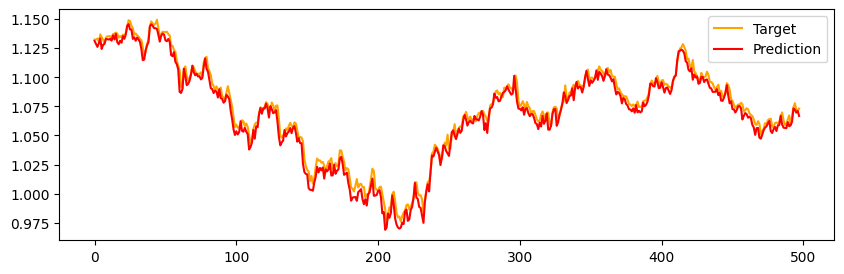

In [63]:
model_cnn_lstm,cnn_history,scaler,test_inputs,test_labels,pred = cocatenated_CNN_RNN(df_stock,300)

In [1]:
profit,list_profit,capital,capital_array,direction = calculate_profit(pred,test_inputs)

NameError: ignored

In [65]:
np.mean(list_profit)

25.96580893449621

In [ ]:
direction

In [67]:
direction.count(0)

107

In [68]:
direction.count(1)

390

In [69]:

variance = sum((x) ** 2 for x in list_profit)


In [70]:
(variance** 0.5)/len(list_profit)

2.122079749691423

In [ ]:
profit

163151.32970613378

In [ ]:
capital_array

In [71]:
capital

361.4554108046754

In [ ]:
df_stock = yf.download('EURGBP=X','2000-01-01','2023-10-14')

In [ ]:
model = run_simple_RNN()
history,predictions = compile_model(model,100)

In [ ]:
model = run_stacked_RNN()
history,predictions = compile_model(model,100)

In [ ]:
history,predictions = compile_model(feedback_model,100)

In [ ]:
history,predictions = time_distributed_CNN_RNN(df_stock,300)

In [ ]:
history,predictions = cocatenated_CNN_RNN(df_stock,200)